## Hcondever variable and frailty index

#### Gavin Qu, May 30th

#### We need to create wave-specific hcondever variables. This involves iterating through each wave and updating the hcondever variable for each wave.

In [15]:
import pandas as pd
import os

# Base directory containing the data files
base_dir = '/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls'

# List of base variable names to extract, including 'pidp'
base_hcond_variables = [
    'pidp', 'hcond1', 'hcond2', 'hcond3', 'hcond4', 'hcond5', 'hcond6', 'hcond7',
    'hcond8', 'hcond9', 'hcond10', 'hcond11', 'hcond12', 'hcond13', 'hcond14',
    'hcond15', 'hcond16', 'hcond17',
    'hcondn1', 'hcondn2', 'hcondn3', 'hcondn4', 'hcondn5', 'hcondn6', 'hcondn7',
    'hcondn8', 'hcondn9', 'hcondn10', 'hcondn11', 'hcondn12', 'hcondn13', 'hcondn14',
    'hcondn15', 'hcondn16', 'hcondn17', 'hcondnew1', 'hcondnew2',
    'hcondnew3', 'hcondnew4', 'hcondnew5', 'hcondnew6', 'hcondnew7', 'hcondnew8',
    'hcondnew10', 'hcondnew11', 'hcondnew12', 'hcondnew13', 'hcondnew14', 'hcondnew15',
    'hcondnew16'
]

base_disdif_variables = [f'disdif{i}' for i in range(1, 12)]

# Combine all variable names to extract
base_variables = ['pidp'] + base_hcond_variables[1:] + base_disdif_variables

# Wave prefixes from 'a' to 'm'
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]

# Function to load and filter wave data
def load_wave_data(wave_prefix, base_dir, base_variables):
    file_path = os.path.join(base_dir, f'{wave_prefix}_indresp.dta')
    if os.path.exists(file_path):
        print(f"Loading data from {file_path}")
        wave_data = pd.read_stata(file_path, convert_categoricals=False)
        
        # Construct the actual variable names for the current wave
        wave_variables = [f'{wave_prefix}_{var}' if var != 'pidp' else var for var in base_variables]
        age_column = f'{wave_prefix}_age_dv'
        wave_variables.append(age_column)
        
        # Find the intersection of desired variables and available columns
        available_columns = set(wave_variables).intersection(wave_data.columns)
        print(f"Available columns in {wave_prefix}: {available_columns}")
        
        # Select only the available columns
        if available_columns:
            selected_data = wave_data[list(available_columns)].copy()
            selected_data['wave'] = wave_prefix
            return selected_data
    return None

# List to store data from each wave
all_waves_data = []

# Loop through wave prefixes
for prefix in wave_prefixes:
    wave_data = load_wave_data(prefix, base_dir, base_variables)
    if wave_data is not None:
        all_waves_data.append(wave_data)

# Combine all waves into a single DataFrame
if all_waves_data:
    combined_data = pd.concat(all_waves_data, ignore_index=True)

    # Load the death information from xhhrel.dta
    death_file_path = os.path.join(base_dir, 'xhhrel.dta')
    death_data = pd.read_stata(death_file_path, convert_categoricals=False)

    # Select the pidp and death column
    death_data = death_data[['pidp', 'dcsedfl_dv']]

    # Merge the death information with the combined data
    combined_data = combined_data.merge(death_data, on='pidp', how='left')

    # List of columns to clean (excluding 'pidp', 'wave', 'dcsedfl_dv', and age columns)
    age_columns = [f'{prefix}_age_dv' for prefix in wave_prefixes]
    columns_to_clean = [col for col in combined_data.columns if col not in ['pidp', 'wave', 'dcsedfl_dv'] + age_columns]

    # Clean the data: treat everything that's not a 1 as 0
    def clean_data(df, columns):
        df_cleaned = df.copy()
        for col in columns:
            df_cleaned[col] = df_cleaned[col].apply(lambda x: 1 if x == 1 else 0)
        return df_cleaned

    # Apply the cleaning function
    cleaned_combined_data = clean_data(combined_data, columns_to_clean)

    # Create wave-specific hcondever variables
    for prefix in wave_prefixes:
        for i in range(1, 18):
            ever_var = f'{prefix}_hcondever{i}'
            cond_cols = [col for col in [f'{prefix}_hcond{i}', f'hcondn{i}', f'hcondnew{i}'] if col in cleaned_combined_data.columns]
            cleaned_combined_data[ever_var] = cleaned_combined_data[cond_cols].max(axis=1)

    # Propagate hcondever values across waves
    for i in range(1, 18):
        for j in range(1, len(wave_prefixes)):
            prev_prefix = wave_prefixes[j-1]
            curr_prefix = wave_prefixes[j]
            prev_var = f'{prev_prefix}_hcondever{i}'
            curr_var = f'{curr_prefix}_hcondever{i}'
            cleaned_combined_data[curr_var] = cleaned_combined_data[[prev_var, curr_var]].max(axis=1)
    
    # Update age for subsequent waves
    for i, prefix in enumerate(wave_prefixes[1:], start=1):
        cleaned_combined_data[f'{prefix}_age_dv'] = cleaned_combined_data[f'a_age_dv'] + i

    # Display the first few rows of the cleaned combined data
    print("Cleaned Combined Data Head:")
    print(cleaned_combined_data.head())

    # Save the cleaned combined data to a new Stata file
    output_dir = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data'
    os.makedirs(output_dir, exist_ok=True)
    cleaned_combined_data_path = os.path.join(output_dir, 'cleaned_combined_ukhls_hcond_disdif_death_data.dta')
    cleaned_combined_data.to_stata(cleaned_combined_data_path, write_index=False)

    print(f"Cleaned combined data saved to {cleaned_combined_data_path}")
else:
    print("No data was loaded. Please check the file paths and variable names.")


Loading data from /Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls/a_indresp.dta
Available columns in a: {'a_disdif6', 'a_hcond15', 'a_disdif9', 'a_hcond3', 'a_hcond6', 'a_hcond14', 'a_disdif3', 'a_hcond1', 'a_disdif8', 'a_disdif11', 'a_hcond8', 'a_disdif7', 'a_hcond2', 'a_hcond10', 'a_hcond16', 'a_hcond9', 'a_disdif2', 'a_disdif1', 'pidp', 'a_hcond12', 'a_hcond4', 'a_disdif5', 'a_hcond5', 'a_hcond7', 'a_disdif10', 'a_hcond13', 'a_hcond17', 'a_disdif4', 'a_age_dv', 'a_hcond11'}
Loading data from /Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls/b_indresp.dta
Available columns in b: {'b_hcondn9', 'b_hcondn10', 'b_disdif9', 'b_hcondn2', 'b_hcondn5', 'b_disdif8', 'b_hcondn16', 'b_hcondn13', 'b_hcondn7', 'b_hcondn8', 'b_hcondn12', 'b_hcondn14', 'b_hcondn6', 'b_hcondn15', 'b_age_dv', 'b_disdif10', 'b_disdif6', 'b_disdif4', 'b_disdif7', 'pidp', 'b_disdif2', 'b_disdif3', 'b_hcondn1', 'b_hcondn17', 'b_disdif5', 'b_hcondn3', 'b_hc

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_52456/547832323.py:33: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  wave_data = pd.read_stata(file_path, convert_categoricals=False)


Available columns in c: {'c_hcond2', 'c_disdif7', 'c_hcondn5', 'c_hcondn15', 'c_disdif1', 'c_hcondn1', 'c_hcondn4', 'c_hcond5', 'c_hcond9', 'c_disdif10', 'c_hcondn17', 'c_hcondn14', 'c_hcond12', 'c_hcondn16', 'c_hcondn10', 'c_hcondn13', 'c_hcond3', 'c_hcondn3', 'pidp', 'c_hcondn2', 'c_hcondn8', 'c_hcondn7', 'c_hcondn11', 'c_hcond14', 'c_disdif2', 'c_hcond17', 'c_hcond16', 'c_disdif3', 'c_hcond11', 'c_hcond6', 'c_hcond4', 'c_hcondn6', 'c_disdif8', 'c_hcond7', 'c_hcond13', 'c_disdif5', 'c_disdif11', 'c_hcondn12', 'c_disdif4', 'c_hcond10', 'c_hcond15', 'c_hcond1', 'c_age_dv', 'c_disdif9', 'c_hcond8', 'c_disdif6', 'c_hcondn9'}
Loading data from /Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls/d_indresp.dta
Available columns in d: {'d_hcond4', 'd_disdif8', 'd_hcond14', 'd_hcond5', 'd_hcondn4', 'd_disdif10', 'd_hcondn12', 'd_disdif4', 'd_hcondn14', 'd_disdif3', 'd_hcond16', 'd_hcond13', 'd_hcond17', 'd_hcondn10', 'd_hcondn3', 'd_hcond15', 'd_hcond12', 'd_disd

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_52456/547832323.py:33: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  wave_data = pd.read_stata(file_path, convert_categoricals=False)


Available columns in e: {'e_age_dv', 'e_hcondn5', 'e_hcondn7', 'e_hcond1', 'e_hcondn8', 'e_hcondn10', 'e_hcond6', 'e_hcond3', 'e_hcond14', 'e_disdif1', 'e_hcond16', 'e_hcondn14', 'e_hcond9', 'e_hcondn13', 'e_hcond4', 'e_hcond7', 'e_disdif9', 'e_hcondn16', 'e_disdif3', 'e_hcondn4', 'e_hcondn2', 'pidp', 'e_disdif6', 'e_hcondn11', 'e_hcondn9', 'e_disdif2', 'e_hcond15', 'e_hcond8', 'e_disdif5', 'e_hcond5', 'e_hcond17', 'e_hcondn1', 'e_hcondn12', 'e_hcondn17', 'e_disdif4', 'e_disdif11', 'e_hcond2', 'e_hcond12', 'e_hcondn3', 'e_disdif8', 'e_hcondn6', 'e_hcond13', 'e_disdif10', 'e_hcond10', 'e_hcondn15', 'e_hcond11', 'e_disdif7'}
Loading data from /Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls/f_indresp.dta
Available columns in f: {'f_hcondn15', 'f_disdif8', 'f_hcond14', 'f_hcond9', 'f_disdif9', 'f_hcond11', 'f_hcondn14', 'f_hcondn11', 'f_disdif6', 'f_hcond16', 'f_hcondn7', 'f_disdif1', 'f_disdif11', 'f_hcond5', 'f_hcondn6', 'f_age_dv', 'f_disdif4', 'f_disdi

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_52456/547832323.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cleaned_combined_data[ever_var] = cleaned_combined_data[cond_cols].max(axis=1)
/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_52456/547832323.py:93: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cleaned_combined_data[ever_var] = cleaned_combined_data[cond_cols].max(axis=1)
/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_52456/547832323.py:93: PerformanceWarning: DataFrame is highl

Cleaned Combined Data Head:
   a_disdif6  a_hcond15  a_disdif9  a_hcond3  a_hcond6  a_hcond14  a_disdif3  \
0          0          0          0         0         0          0          0   
1          0          0          0         0         0          0          0   
2          0          0          0         0         0          0          0   
3          0          0          0         0         0          0          0   
4          0          0          0         0         0          0          0   

   a_hcond1  a_disdif8  a_disdif11  ...  m_hcondever8  m_hcondever9  \
0         1          0           0  ...           0.0           0.0   
1         0          0           0  ...           0.0           0.0   
2         0          0           0  ...           0.0           0.0   
3         0          0           0  ...           0.0           0.0   
4         1          0           0  ...           0.0           0.0   

   m_hcondever10  m_hcondever11  m_hcondever12  m_hcondever13  m

#### Non-zero counts of hcond and disdif

In [16]:
import pandas as pd

# Define file paths
cleaned_combined_data_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/cleaned_combined_ukhls_hcond_disdif_death_data.dta'

# Load the cleaned combined data
cleaned_combined_data = pd.read_stata(cleaned_combined_data_path)

# Define wave prefixes
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]

# Initialize a dictionary to store counts
hcondever_counts = {
    'Wave': [],
    'Health Condition': [],
    'Non-zero Count': []
}

# Count non-zero values for wave-specific hcondever variables
for prefix in wave_prefixes:
    for i in range(1, 18):
        hcondever_var = f'{prefix}_hcondever{i}'
        if hcondever_var in cleaned_combined_data.columns:
            non_zero_count = cleaned_combined_data[hcondever_var].sum()
            hcondever_counts['Wave'].append(prefix)
            hcondever_counts['Health Condition'].append(f'hcondever{i}')
            hcondever_counts['Non-zero Count'].append(non_zero_count)

# Convert the dictionary to a DataFrame
hcondever_counts_df = pd.DataFrame(hcondever_counts)

# Save the counts to a CSV file
output_dir = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data'
hcondever_counts_path = os.path.join(output_dir, 'hcondever_nonzero_counts.csv')
hcondever_counts_df.to_csv(hcondever_counts_path, index=False)

# Display the counts
print("Non-zero counts of wave-specific hcondever variables:")
print(hcondever_counts_df)


Non-zero counts of wave-specific hcondever variables:
    Wave Health Condition  Non-zero Count
0      a       hcondever1          6269.0
1      a       hcondever2          6769.0
2      a       hcondever3           276.0
3      a       hcondever4           854.0
4      a       hcondever5          1353.0
..   ...              ...             ...
216    m      hcondever13          1864.0
217    m      hcondever14          3531.0
218    m      hcondever15           692.0
219    m      hcondever16          9935.0
220    m      hcondever17          3759.0

[221 rows x 3 columns]


### Frailty index with death counted as 1 using the hcondever and disdiff variables

In [17]:
import pandas as pd
import os

# Define file paths
base_dir = '/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls'
cleaned_combined_data_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/cleaned_combined_ukhls_hcond_disdif_death_data.dta'
frailty_index_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_index_with_death.dta'

# Load the cleaned combined data
cleaned_combined_data = pd.read_stata(cleaned_combined_data_path)

# Load the death information from xhhrel.dta
death_file_path = os.path.join(base_dir, 'xhhrel.dta')
death_data = pd.read_stata(death_file_path, convert_categoricals=False)

# Extract the pidp and dcsedw_dv (death wave)
death_data = death_data[['pidp', 'dcsedw_dv']]

# Map death wave values to corresponding wave prefixes
death_wave_map = {
    20: 'b', 21: 'c', 22: 'd', 23: 'e', 24: 'f', 25: 'g',
    26: 'h', 27: 'i', 28: 'j', 29: 'k', 30: 'l', 31: 'm'
}

# Function to filter individuals aged 20 and above
def filter_age_range(df, age_start, wave_prefixes):
    age_columns = [f'{prefix}_age_dv' for prefix in wave_prefixes]
    filtered_dfs = []
    for i, age_column in enumerate(age_columns):
        if age_column in df.columns:
            age_data = df[['pidp', age_column]].copy()
            age_data.rename(columns={age_column: 'age'}, inplace=True)
            age_data['wave'] = wave_prefixes[i]
            age_data['age'] += i  # Add years for subsequent waves
            filtered_dfs.append(age_data[age_data['age'] >= age_start])
    return pd.concat(filtered_dfs, ignore_index=True)

# Define wave prefixes
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]

# Filter individuals aged 20 and above
filtered_data = filter_age_range(cleaned_combined_data, 20, wave_prefixes)

# Merge filtered data with the original cleaned data to get other variables
merged_data = pd.merge(filtered_data, cleaned_combined_data, on=['pidp', 'wave'])

# Create wave-specific hcondever variables
for prefix in wave_prefixes:
    for i in range(1, 18):
        ever_var = f'{prefix}_hcondever{i}'
        cond_cols = [col for col in [f'{prefix}_hcond{i}', f'hcondn{i}', f'hcondnew{i}'] if col in merged_data.columns]
        merged_data[ever_var] = merged_data[cond_cols].max(axis=1)

# Function to calculate the frailty index for each wave
def calculate_frailty_index(df, wave_prefixes):
    for prefix in wave_prefixes:
        relevant_columns = [f'{prefix}_hcondever{i}' for i in range(1, 18)] + [f'{prefix}_disdif{i}' for i in range(1, 12)]
        frailty_col = f'{prefix}_frailty'
        df[frailty_col] = df[relevant_columns].sum(axis=1) / len(relevant_columns)
        df[frailty_col] = df[frailty_col].round(5)
    return df

# Calculate the frailty index for each wave
frailty_data = calculate_frailty_index(merged_data, wave_prefixes)

# Update the frailty index for deceased individuals
for wave_value, wave_prefix in death_wave_map.items():
    death_pids = death_data[death_data['dcsedw_dv'] == wave_value]['pidp']
    frailty_data.loc[frailty_data['pidp'].isin(death_pids), f'{wave_prefix}_frailty'] = 1

# Display the first few rows of the frailty data
print("Frailty Data Head:")
print(frailty_data[[col for col in frailty_data.columns if 'frailty' in col]].head())

# Save the frailty index data to a Stata file
frailty_data.to_stata(frailty_index_path, write_index=False)

print(f"Frailty index data saved to {frailty_index_path}")


/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_52456/1111299552.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[frailty_col] = df[relevant_columns].sum(axis=1) / len(relevant_columns)
/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_52456/1111299552.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[frailty_col] = df[relevant_columns].sum(axis=1) / len(relevant_columns)
/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_52456/1111299552.py:59: PerformanceWarning: DataFrame is highly fra

Frailty Data Head:
   a_frailty  b_frailty  c_frailty  d_frailty  e_frailty  f_frailty  \
0    0.03571        0.0        0.0        0.0        0.0        0.0   
1    0.00000        0.0        0.0        0.0        0.0        0.0   
2    0.03571        0.0        0.0        0.0        0.0        0.0   
3    0.25000        0.0        0.0        0.0        0.0        0.0   
4    0.07143        0.0        0.0        0.0        0.0        0.0   

   g_frailty  h_frailty  i_frailty  j_frailty  k_frailty  l_frailty  m_frailty  
0        0.0        0.0        0.0        0.0        0.0        0.0        0.0  
1        0.0        0.0        0.0        0.0        0.0        0.0        0.0  
2        0.0        0.0        0.0        0.0        0.0        0.0        0.0  
3        0.0        0.0        0.0        1.0        0.0        0.0        0.0  
4        0.0        0.0        0.0        0.0        0.0        0.0        0.0  
Frailty index data saved to /Users/gavinqu/Desktop/School/Dissertati

#### Non-zero count of frailty for each wave

In [18]:
import pandas as pd

# Load the frailty index data
frailty_index_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_index_with_death.dta'
frailty_data = pd.read_stata(frailty_index_path)

# Define wave prefixes
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]

# Initialize a dictionary to store counts
frailty_counts = {
    'Wave': [],
    'Non-zero Frailty Count': []
}

# Calculate the non-zero counts for each wave
for prefix in wave_prefixes:
    frailty_col = f'{prefix}_frailty'
    if frailty_col in frailty_data.columns:
        non_zero_count = (frailty_data[frailty_col] > 0).sum()
        frailty_counts['Wave'].append(prefix)
        frailty_counts['Non-zero Frailty Count'].append(non_zero_count)

# Convert the dictionary to a DataFrame
frailty_counts_df = pd.DataFrame(frailty_counts)

# Display the counts
print("Non-zero Frailty Index Counts:")
print(frailty_counts_df)

# Save the counts to a CSV file
output_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/non_zero_frailty_counts.csv'
frailty_counts_df.to_csv(output_path, index=False)
print(f"Non-zero frailty counts saved to {output_path}")


Non-zero Frailty Index Counts:
   Wave  Non-zero Frailty Count
0     a                   23641
1     b                    8014
2     c                    7441
3     d                    7107
4     e                    6688
5     f                    6326
6     g                    6447
7     h                    7528
8     i                    7000
9     j                    7065
10    k                    6775
11    l                    6227
12    m                    6073
Non-zero frailty counts saved to /Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/non_zero_frailty_counts.csv


### Smoothed Line Plot of Frailty against Age 

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_52456/1013468238.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='age', y='frailty_index', data=scatter_data, ci='sd')


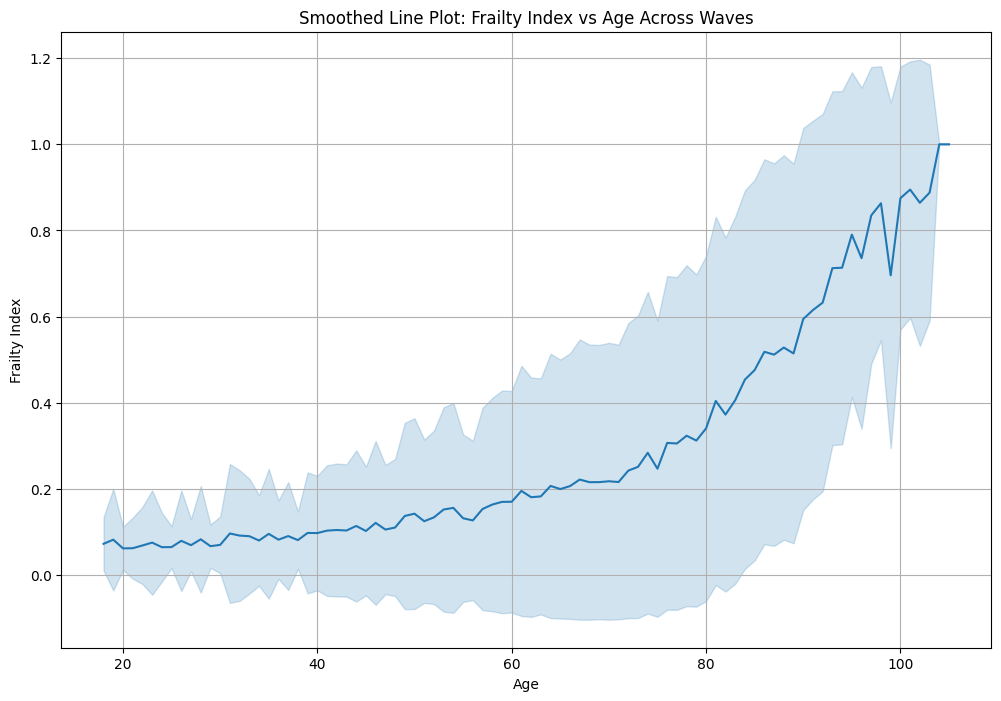

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the frailty index data
frailty_index_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_index_with_death.dta'
frailty_data = pd.read_stata(frailty_index_path)

# Load the cleaned combined data to get the age variables
cleaned_combined_data_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/cleaned_combined_ukhls_hcond_disdif_death_data.dta'
combined_data = pd.read_stata(cleaned_combined_data_path)

# Define wave prefixes and age column prefixes
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]
age_columns = [f'{prefix}_age_dv' for prefix in wave_prefixes]

# Prepare data for the smoothed line plot
scatter_data = pd.DataFrame()

for prefix in wave_prefixes:
    frailty_col = f'{prefix}_frailty'
    age_col = f'{prefix}_age_dv'
    if frailty_col in frailty_data.columns and age_col in combined_data.columns:
        temp_df = frailty_data[['pidp', frailty_col]].copy()
        temp_age_df = combined_data[['pidp', age_col]].copy()
        temp_df = temp_df.merge(temp_age_df, on='pidp')
        temp_df = temp_df[temp_df[frailty_col] > 0]  # Filter out zero frailty index values
        temp_df['wave'] = prefix
        temp_df = temp_df.rename(columns={frailty_col: 'frailty_index', age_col: 'age'})
        scatter_data = pd.concat([scatter_data, temp_df], ignore_index=True)

# Create smoothed line plot
plt.figure(figsize=(12, 8))
sns.lineplot(x='age', y='frailty_index', data=scatter_data, ci='sd')
plt.xlabel('Age')
plt.ylabel('Frailty Index')
plt.title('Smoothed Line Plot: Frailty Index vs Age Across Waves')
plt.grid(True)
plt.show()
